# Importing Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

pd.set_option('display.max_rows', 15)

# Data Fetch & Clean

In [2]:
#assuming daily data with trading days only
ticker_list = ['ntn1m', 'ntn3m','usdtwd']
folder_pathname = r'data'
df_list = []


for ticker in ticker_list:
    df = pd.read_csv(folder_pathname + "\\" + ticker + '.csv', index_col = 'date', parse_dates=True)
    df.columns = [ticker]
    df_list.append(df)

data_df = pd.concat(df_list,axis=1)

data_df['ntn1m3m'] = data_df['ntn3m'] - data_df['ntn1m']

In [3]:
data_df

,ntn1m,ntn3m,usdtwd,ntn1m3m
date,,,,
2010-01-01,-0.375,-0.455,31.974,-0.080
2010-01-04,-0.225,-0.505,31.743,-0.280
2010-01-05,-0.120,-0.380,31.840,-0.260
2010-01-06,-0.170,-0.400,31.865,-0.230
2010-01-07,-0.110,-0.350,31.870,-0.240
...,...,...,...,...
2020-11-27,-0.098,-0.440,28.658,-0.342
2020-11-30,-0.071,-0.412,28.663,-0.341
2020-12-01,-0.046,-0.355,28.676,-0.309


## Train Test Set Splitting

In [4]:
#test set start date (inclusive of this date)
train_test_split_date = '2015-12-31'
row_number = data_df.index.get_loc(train_test_split_date)

train_df = data_df.iloc[:row_number, :].dropna()
test_df = data_df.iloc[row_number:, :].dropna()

# Strategy Development

In [5]:
#input lookback and lookahead returns
lookback_period = input("lookback period: ")
lookahead_period = input("lookahead period: ")

period_dict = {
    'd': 1,
    'w': 5,
    'm': 22,
    'q': 66,
    'y': 252
}


lookback = period_dict[lookback_period[-1]] * int(lookback_period[:-1])
lookahead = period_dict[lookahead_period[-1]] * int(lookahead_period[:-1])

lookback period: 1w
lookahead period: 1w


In [6]:
#calculating ntn1m lookback return
train_df['lookback_return' + "_" + lookback_period] = (train_df['ntn1m'] - train_df['ntn1m'].shift(lookback)) / train_df['usdtwd']

#calculating ntn1m3m lookahead return
train_df['lookahead_return' + "_" + lookahead_period] = (train_df['ntn1m3m'].shift(-lookahead) - train_df['ntn1m3m']) / train_df['usdtwd']

In [7]:
train_df.dropna()

,ntn1m,ntn3m,usdtwd,ntn1m3m,lookback_return_1w,lookahead_return_1w
date,,,,,,
2010-01-08,-0.170,-0.420,31.873,-0.250,0.006432,0.000941
2010-01-11,-0.165,-0.410,31.764,-0.245,0.001889,0.000630
2010-01-12,-0.135,-0.375,31.778,-0.240,-0.000472,0.000629
2010-01-13,-0.105,-0.340,31.804,-0.235,0.002044,0.000943
2010-01-14,-0.065,-0.295,31.743,-0.230,0.001418,0.000315
...,...,...,...,...,...,...
2015-12-17,0.045,0.045,32.901,0.000,-0.000760,0.000000
2015-12-18,0.061,0.073,32.967,0.012,0.000485,-0.000212
2015-12-21,0.038,0.041,32.951,0.003,-0.000819,0.001001


## Calculating Z-scores based on the train set

In [8]:
lookback_mean = np.mean(train_df['lookback_return' + "_" + lookback_period])
lookback_std = np.std(train_df['lookback_return' + "_" + lookback_period])

train_df['lookback_zscore'+ "_" + lookback_period] = (train_df['lookback_return' + "_" + lookback_period] - lookback_mean) / lookback_std
train_df['lookahead_zscore'+ "_" + lookahead_period] = (train_df['lookahead_return' + "_" + lookahead_period] - np.mean(train_df['lookahead_return' + "_" + lookahead_period]))/np.std(train_df['lookahead_return' + "_" + lookahead_period])

<AxesSubplot:xlabel='lookback_zscore_1w', ylabel='Count'>

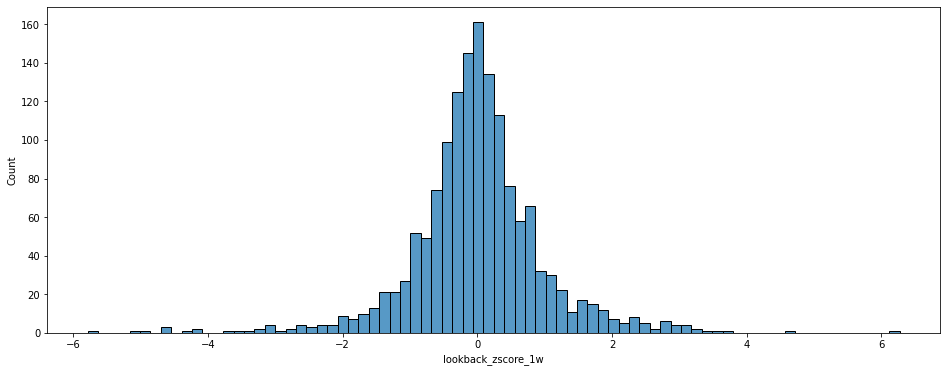

In [9]:
plt.figure(figsize=(16, 6))
sns.histplot(train_df['lookback_zscore'+ "_" + lookback_period])

## Visualizing a joint distribution of lookback and lookahead returns

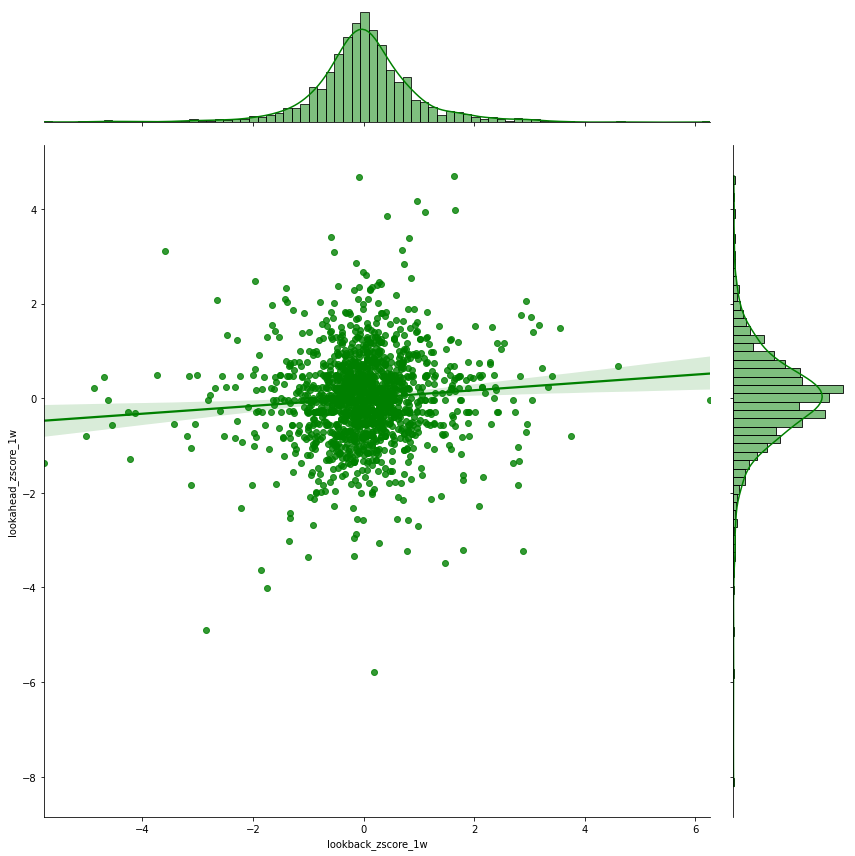

In [10]:
sns.jointplot(data=train_df, height = 12, x='lookback_zscore'+ "_" + lookback_period, y='lookahead_zscore'+ "_" + lookahead_period, kind='reg', color='g');

In [11]:
correl = train_df['lookback_zscore'+ "_" + lookback_period].corr(train_df['lookahead_zscore'+ "_" + lookahead_period])
print("Correlation: ", correl)

Correlation:  0.08470069233386447


In [12]:
#Regresing lookback returns with lookahead returns
X = train_df.dropna()['lookback_return'+ "_" + lookback_period]
X = sm.add_constant(X)
y = train_df.dropna()['lookahead_return'+ "_" + lookahead_period]
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     lookahead_return_1w   R-squared:                       0.007
Model:                             OLS   Adj. R-squared:                  0.007
Method:                  Least Squares   F-statistic:                     10.67
Date:                 Wed, 09 Dec 2020   Prob (F-statistic):            0.00112
Time:                         17:50:21   Log-Likelihood:                 8786.0
No. Observations:                 1478   AIC:                        -1.757e+04
Df Residuals:                     1476   BIC:                        -1.756e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.598e

## Dividing the lookback zscore into bins

In [13]:
#bins_list = [-100,-3,-2,-1,0,1,2,3,100]
train_df['lookahead_zscore'+ "_" + lookahead_period].groupby(pd.cut(train_df['lookback_zscore'+ "_" + lookback_period], bins=11)).describe()

,count,mean,std,min,25%,50%,75%,max
lookback_zscore_1w,,,,,,,,
"(-5.796, -4.688]",4.0,-0.374801,0.849260,-1.362333,-0.935370,-0.288905,0.271664,0.440938
"(-4.688, -3.592]",7.0,0.155118,1.406354,-1.292554,-0.435015,-0.300197,0.223021,3.102567
"(-3.592, -2.496]",15.0,-0.467354,1.517620,-4.899137,-0.800348,-0.274170,0.340234,2.079016
"(-2.496, -1.4]",55.0,-0.025889,1.255637,-4.010471,-0.683369,0.011496,0.498276,2.482749
"(-1.4, -0.305]",396.0,-0.096073,0.902408,-3.356111,-0.658641,-0.037305,0.450768,3.401125
"(-0.305, 0.791]",783.0,0.033624,0.920109,-5.786181,-0.466863,0.013611,0.492156,4.684226
"(0.791, 1.887]",165.0,0.111387,1.175118,-3.474432,-0.536419,0.059961,0.642005,4.700187
"(1.887, 2.983]",42.0,0.007708,1.085153,-3.220009,-0.479096,0.201753,0.668347,2.046854
"(2.983, 4.079]",9.0,0.741451,0.859303,-0.793073,0.231203,0.638556,1.490570,1.720791


# Strategy Back-testing

## Back-testing module development

In [14]:
def backtest(df, holding_period = 22, take_profit = 0.10, stop_loss = 0.03, return_type = 'percent'):
    if return_type == 'absolute':
        df['daily_return'] = df['points'].diff()
    elif return_type == 'percent':
        df['daily_return'] = df['points'].pct_change()
        df['daily_return'].replace(np.inf, 0, inplace=True)
        df['daily_return'].replace(-np.inf, 0, inplace=True)
        df['daily_return'].replace(-np.nan, 0, inplace=True)
    elif return_type == 'points':
        df['daily_return'] = df['points'].diff() / df['spot']
       # df['daily_return'] = df['daily_return']
    else:
        df['daily_return'] = df['points'].diff()
    
    df['pnl'] = 0.0
    df['position'] = 0.0
    df['in_trade'] = False
    df['trade_pnl'] = 0.0
    df['trade_id'] = 0.0
    df['exit_status'] = ""
    
    position = 0
    trade_id = 0
    in_trade = False
    trade_pnl = 0.0
    trade_max_pnl = 0.0
    trade_days = 0.0
    
    for i in range(df.shape[0]):
        df['position'].iloc[i] = position
        df['in_trade'].iloc[i] = in_trade
        
        if i >= 1:
            if return_type == 'absolute':
                df['pnl'].iloc[i] = position * df['daily_return'].iloc[i]
            else:
                df['pnl'].iloc[i] = position * df['daily_return'].iloc[i]
                   
        if in_trade:
            if return_type == 'absolute':
                trade_pnl = trade_pnl + df['pnl'].iloc[i]
            else:
                trade_pnl = (1 + trade_pnl) * (1 + df['pnl'].iloc[i]) - 1
            
            trade_days += 1
            trade_max_pnl = max(trade_pnl, trade_max_pnl)
            df['trade_pnl'].iloc[i] = trade_pnl
            
            
            if position == -1 * df['signal'].iloc[i]:
                position = df['signal'].iloc[i]
                trade_id += 1
                df['trade_id'].iloc[i] = trade_id
                trade_pnl = 0.0
                trade_max_pnl = 0.0
                trade_days = 0.0
                df['exit_status'].iloc[i] = 'reversal'
                continue
            
            if trade_days >= holding_period:
                in_trade = False
                position = 0
                df['exit_status'].iloc[i] = 'holding period'
                continue
                
            if trade_pnl >= take_profit:
                in_trade = False
                position = 0
                df['exit_status'].iloc[i] = 'take profit'
                continue
            
            if trade_max_pnl - trade_pnl >= stop_loss:
                in_trade = False
                position = 0
                df['exit_status'].iloc[i] = 'stop loss'
                continue
        else:
            position = df['signal'].iloc[i]
            if position != 0:
                in_trade = True
                trade_id += 1
                df['trade_id'].iloc[i] = trade_id
                trade_pnl = 0.0
                trade_max_pnl = 0.0
                trade_days = 0.0
           

## Test Set signal generation and calling the backtest module

C:\ProgramData\Anaconda3\envs\dev1\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


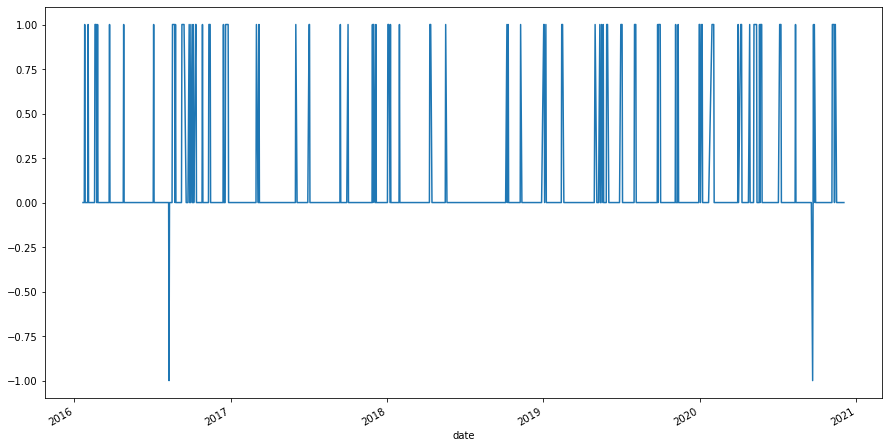

In [23]:
# strategy, say:
# short twd 1m3m points when the z-score of twd 1m points 1w return is between -3.5 and -2.5
# long  twd 1m3m points when the z-score of twd 1m points 1w return is between 0.8 and 1.9
#holding period is 1w 

#calculating ntn1m lookback return
test_df['lookback_return' + "_" + lookback_period] = (test_df['ntn1m'] - test_df['ntn1m'].shift(lookback)) / test_df['usdtwd']
test_df['lookback_zscore'+ "_" + lookback_period] = (test_df['lookback_return' + "_" + lookback_period] - lookback_mean) / lookback_std
test_df.dropna(inplace=True)

df = pd.DataFrame(test_df['ntn1m3m'])
df.rename(columns = {'ntn1m3m' : 'points'}, inplace = True)
df['spot'] = test_df['usdtwd']
#1 is buy, 0 is hold, -1 is sell
df['signal'] = np.where(
    (test_df['lookback_zscore_1w'] <= -2.5) & (test_df['lookback_zscore_1w'] > -3.5), -1, 
    np.where(
        (test_df['lookback_zscore_1w'] <= 1.9) & (test_df['lookback_zscore_1w'] > 0.8), 1, 0)
)
df['signal'].plot(figsize=(15,8))
df.dropna(inplace=True)

backtest(df, holding_period = 5, take_profit = 0.01, stop_loss = 0.005, return_type = 'points')

## Analysis of results

In [24]:
pd.set_option('display.max_rows', 100)
df['cumpnl'] = (1+df['pnl']).cumprod() - 1

window = 252
df['daily_drawdown'] = df['cumpnl'] - df['cumpnl'].rolling(window, min_periods=1).max()
df['max_daily_drawdown'] = df['daily_drawdown'].rolling(window, min_periods=1).min()


## Cumulative PnL

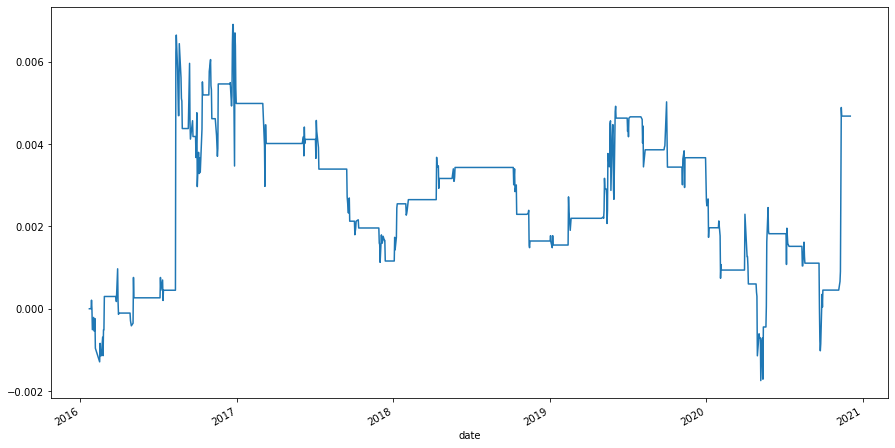

In [25]:
df['cumpnl'].plot(figsize=(15,8));

## Max Daily Drawdown in rolling 252d window

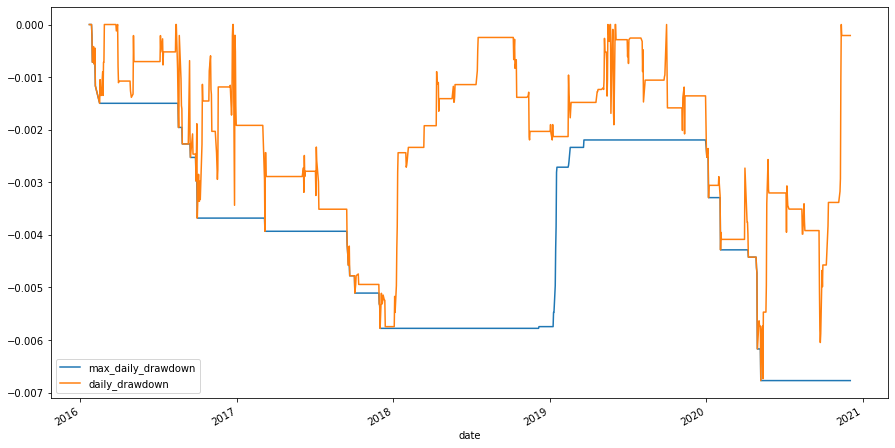

In [26]:
df.plot(y=['max_daily_drawdown', 'daily_drawdown'], figsize=(15,8));

## Rolling 252d Volatility of returns

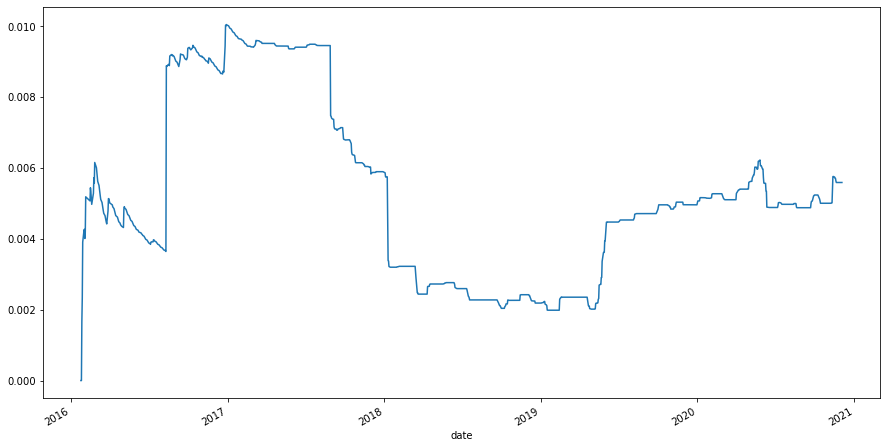

In [27]:
df['vol'] = (df['pnl'].rolling(window, min_periods = 1).std()*(252 ** 0.5))
df['vol'].plot(figsize=(15,8));

## Rolling 252d Cumulative Returns

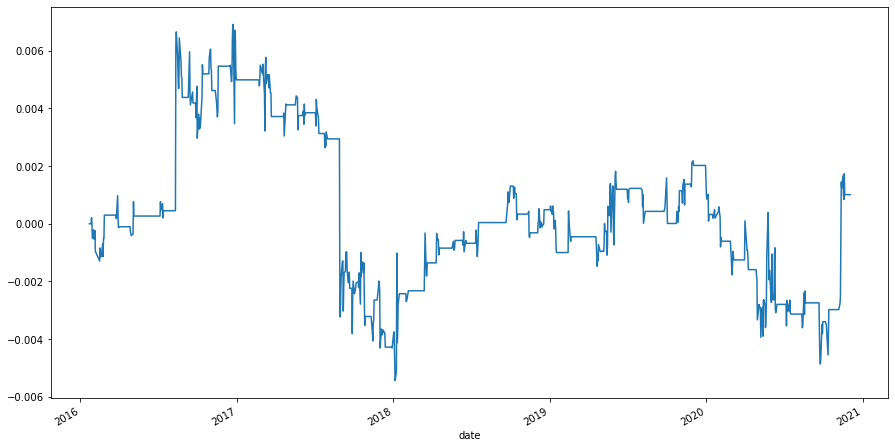

In [28]:
df['return'] = ((1.0 + df['pnl']).rolling(window, min_periods = 1).apply(np.prod, raw=True) - 1)
df['return'].plot(figsize=(15,8));

## Rolling 252d Sharpe (ignoring risk free rate)

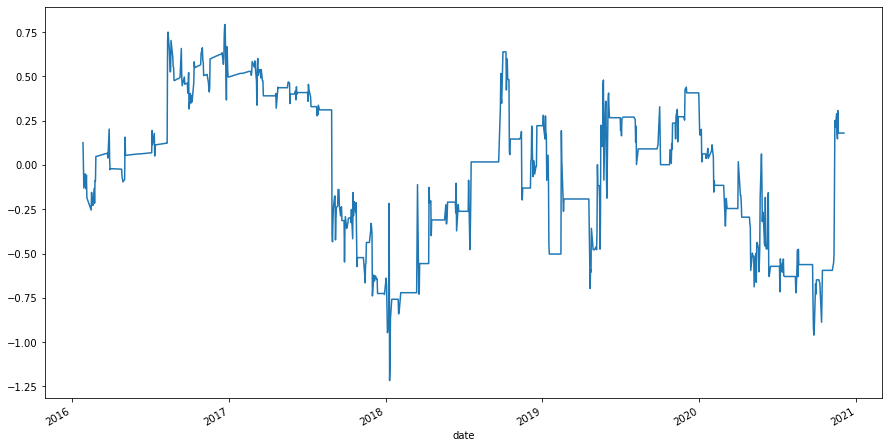

In [29]:
(df['return']/df['vol']).plot(figsize=(15,8));